In [1]:
from pathlib import Path
import pandas as pd
from datetime import datetime

#use concat to merge all of files together
list_stacked = pd.DataFrame() 
current_path = Path()/'CSV'
for folder in current_path.absolute().glob('*'):
    for file in folder.glob('H_lvr_land_A.csv'):
        data = pd.read_csv(file)[1:]
        list_stacked = pd.concat([list_stacked, data])

#----------------------------------------------------------------------------------------------------------------------------
#Originally, there are 33 columns in the file; select 18 columns which need to be analyzed
data = list_stacked[['鄉鎮市區', '土地位置建物門牌', '土地移轉總面積平方公尺', '交易年月日', '總樓層數', '建物型態', '建物移轉總面積平方公尺', '總價元',
                     '單價元平方公尺', '主建物面積']]

#----------------------------------------------------------------------------------------------------------------------------
#坪 is the most popular unit that Taiwanese to measure the property, so we need to transfer from meter squared to 坪
data = data.copy()
data = data[data['鄉鎮市區'].notna()]
data['土地移轉總面積坪'] = data['土地移轉總面積平方公尺'].astype(float)*3.3058
data['建物移轉總面積坪'] = data['建物移轉總面積平方公尺'].astype(float)*3.3058
data['單價元坪'] = data['單價元平方公尺'].astype(float)*3.3058
data['主建物面積'] = data['主建物面積'].astype(float)*3.3058
data['總價元'] = data['總價元'].astype(float)
data['交易年月日'] = pd.to_datetime((data['交易年月日'].astype(int)+19110000).astype(str), format = '%Y%m%d', errors='coerce') #轉換成日期型態
condition = (data['交易年月日'] >= '2020-10-01') & (data['交易年月日'] <= '2023-09-30') # 篩選資料，只篩選過去36個月的資料
data = data[condition]

data['Year'] = data['交易年月日'].dt.year.fillna(0).astype(int)
data['Quarter'] = data['交易年月日'].dt.quarter.fillna(0).astype(int)
data['Month'] = data['交易年月日'].dt.month.fillna(0).astype(int).map("{:02}".format)
data['Day'] = data['交易年月日'].dt.day.fillna(0).astype(int)

# # #----------------------------------------------------------------------------------------------------------------------------

data = data.where(pd.notnull(data), None)


In [2]:
lst = []
for year, month in zip(data['Year'],data['Month']):
    lst.append('-'.join(str(i) for i in [year, month]))
data['Yearmonth'] = lst
data['Yearmonth'] = pd.to_datetime(data['Yearmonth'], format='%Y-%m').dt.to_period('M')


In [3]:
# dataset2，使用者自行選擇產業，之後依ROE排序列印出來
# 判斷使用者使用環境
from sys import platform
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

if platform == 'darwin':
    # 設定中文字體
    plt.rcParams['font.family'] = 'Arial Unicode MS'  # 使用 macOS 的內建中文字體

    # 使用中文字體
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

elif platform == 'win32':
    # 设置中文字体路径
    font_path = r'C:\Windows\Fonts'  # 替换为你下载的中文字体文件路径

    # 设置中文字体
    custom_font = FontProperties(fname=font_path)

    # 使用中文字体
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 替換為你選擇的繁體中文字體
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from datetime import datetime
import numpy as np

/var/folders/mm/8z_b2s6d74n1v0_mlvkzqqrh0000gn/T/ipykernel_51889/3745508816.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([f'{int(i):,}' for i in ax1.get_yticks()], fontsize=20)
/var/folders/mm/8z_b2s6d74n1v0_mlvkzqqrh0000gn/T/ipykernel_51889/3745508816.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f'{int(i):,}' for i in ax2.get_yticks()], fontsize=20)


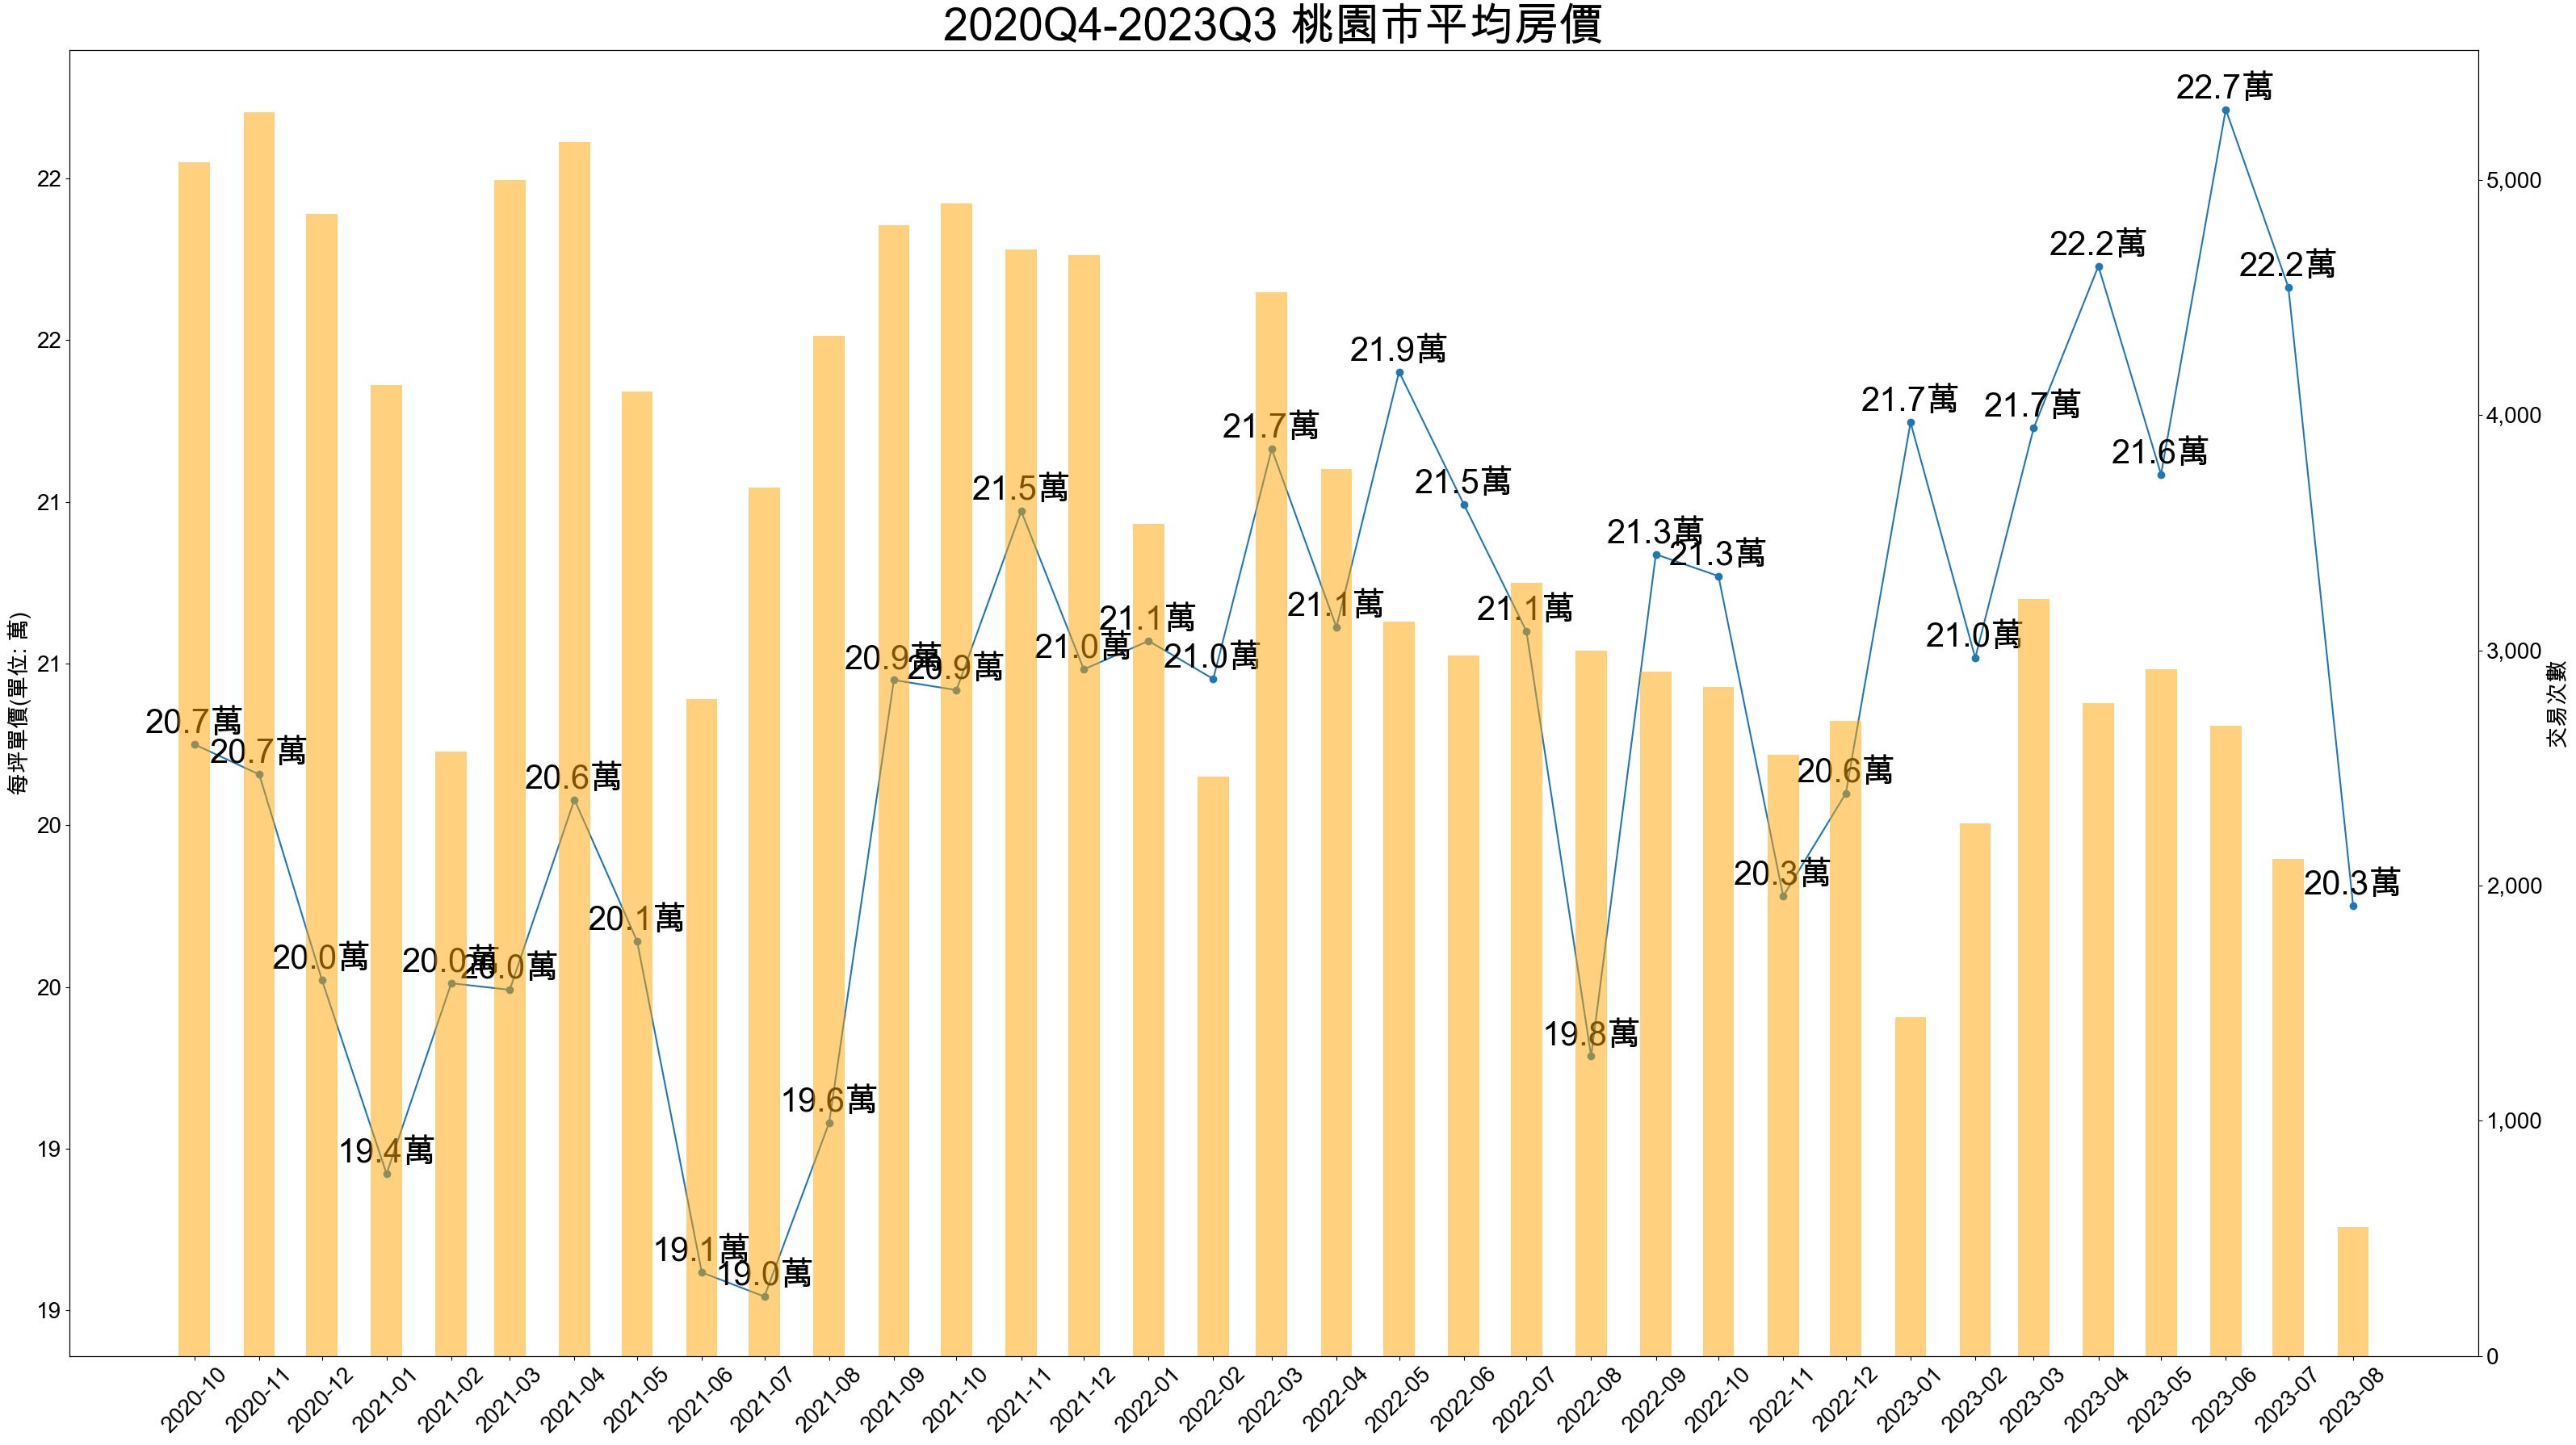

In [5]:
x_values = sorted(set(lst))
dates = [datetime.strptime(date, '%Y-%m') for date in x_values]
x_values_numeric = date2num(dates)

y = list(data.groupby(['Yearmonth'])['單價元坪'].mean())
y_values = [int(i)/10000 for i in y]

# Count the number of entries for each unique year-month combination
entry_counts = data['Yearmonth'].value_counts().sort_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(32, 18))

# Line chart
ax1.plot(x_values_numeric, y_values, marker='o', label='Average Price')

# Set the x-axis ticks to be the original date strings
ax1.set_xticks(dates)
ax1.set_xticklabels(x_values, rotation=45, fontsize=20)

# Add labels and title for the line chart
ax1.set_ylabel('每坪單價(單位: 萬)', fontsize=20)
ax1.set_yticklabels([f'{int(i):,}' for i in ax1.get_yticks()], fontsize=20)
Taoyuan = ax1.set_title("2020Q4-2023Q3 桃園市平均房價", fontsize=40)

# Annotate the data points on the line chart
for i, txt in enumerate(y_values):
    ax1.annotate(f'{txt:.1f}萬', (x_values_numeric[i], y_values[i]),
                 textcoords="offset points", xytext=(0, 10), ha='center', size=30)

# Bar chart
ax2 = ax1.twinx()  # Create a second y-axis to overlay the bar chart
ax2.bar(x_values_numeric, entry_counts, alpha=0.5, color='orange', width=15)

# Add labels and title for the bar chart
ax2.set_ylabel('交易次數', fontsize=20)
ax2.set_yticklabels([f'{int(i):,}' for i in ax2.get_yticks()], fontsize=20)

# Adjust layout to prevent label overlap
fig.tight_layout()

# # save the plot with title named
# filename = '2020Q4-2023Q3 桃園市平均房價價格和交易次數.png'
# plt.savefig(filename)

# Show the chart
plt.show()


In [6]:
# # # #----------------------------------------------------------------------------------------------------------------------------
df = pd.DataFrame({'Price': y_values, 'Count': entry_counts})
df['Price'] = df['Price'].round(1)
df['Count'] = df['Count'].apply(lambda x: f'{x:.0f}')
df.transpose()


Yearmonth,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Price,20.7,20.7,20.0,19.4,20.0,20.0,20.6,20.1,19.1,19.0,...,20.3,20.6,21.7,21.0,21.7,22.2,21.6,22.7,22.2,20.3
Count,5077,5288,4855,4128,2569,5001,5160,4100,2794,3691,...,2555,2701,1440,2265,3218,2774,2920,2679,2113,548


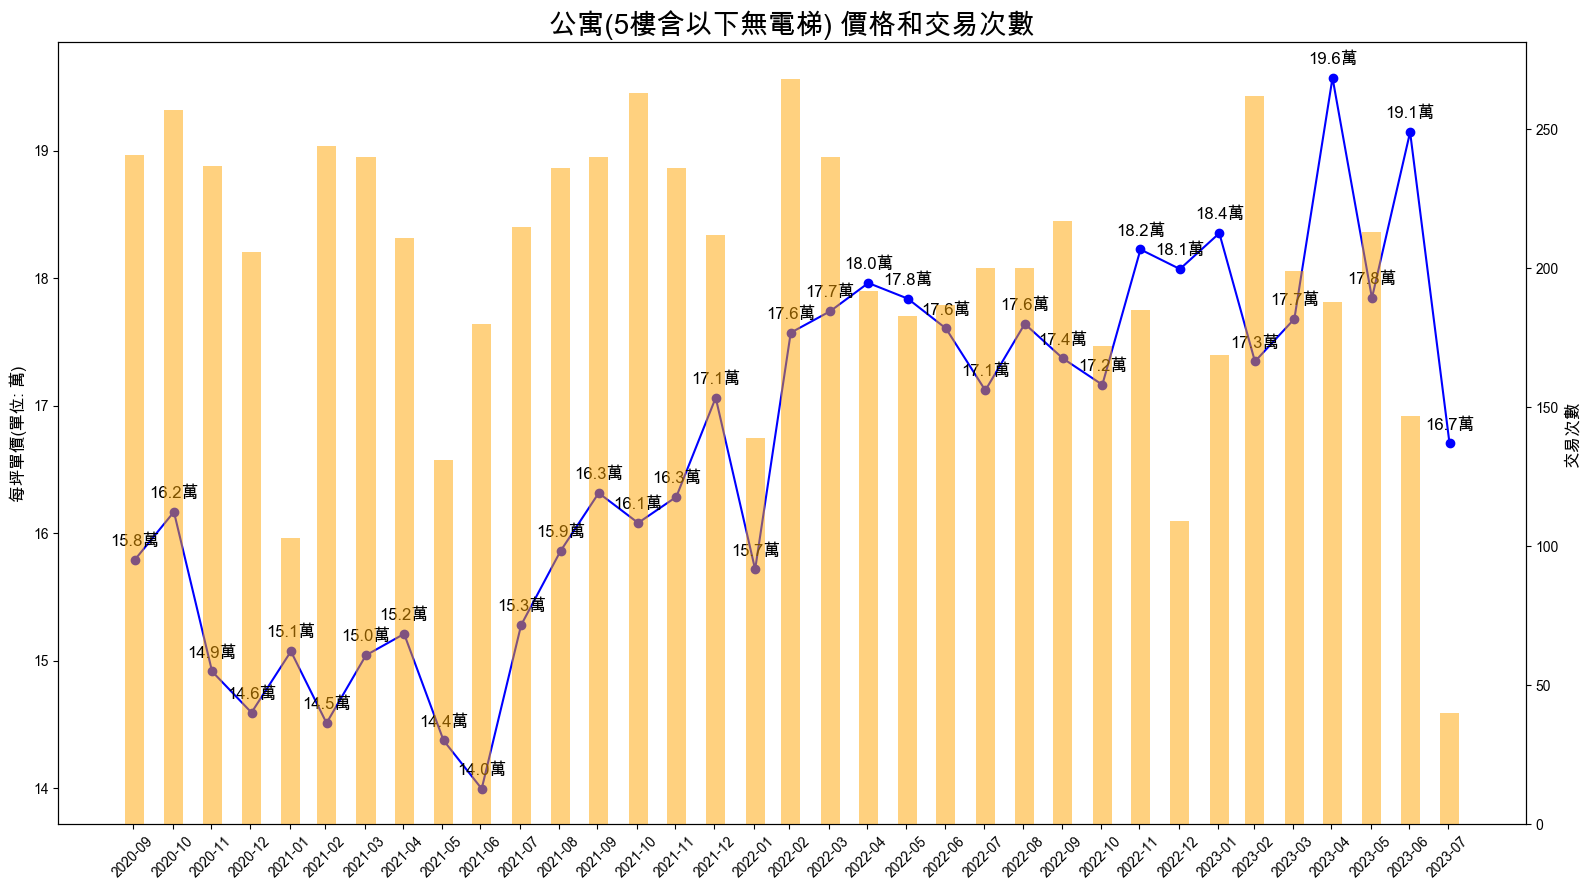

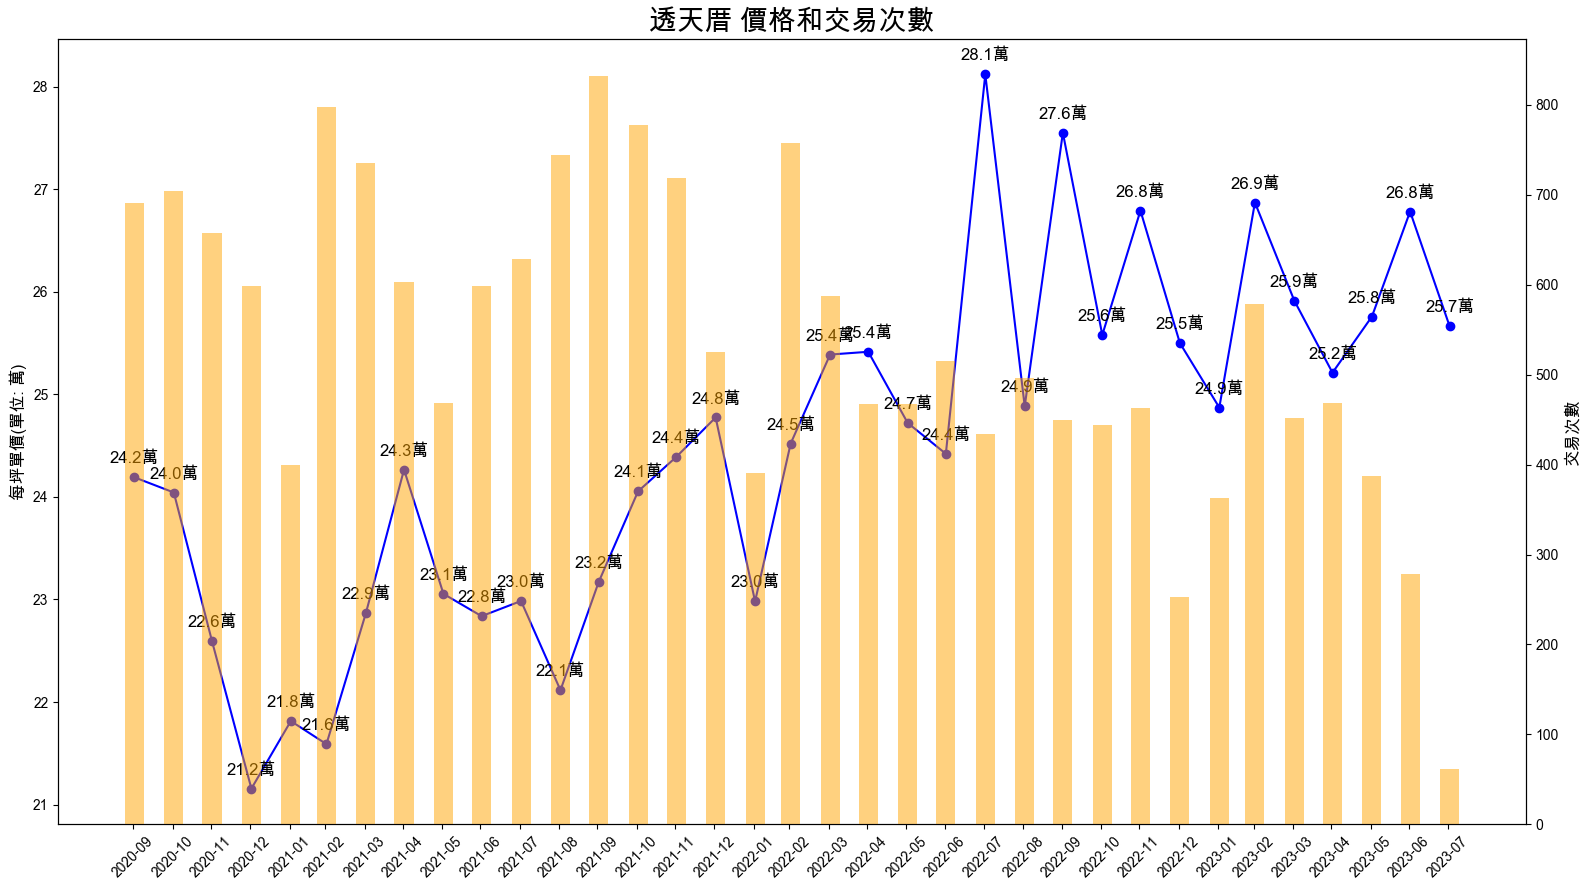

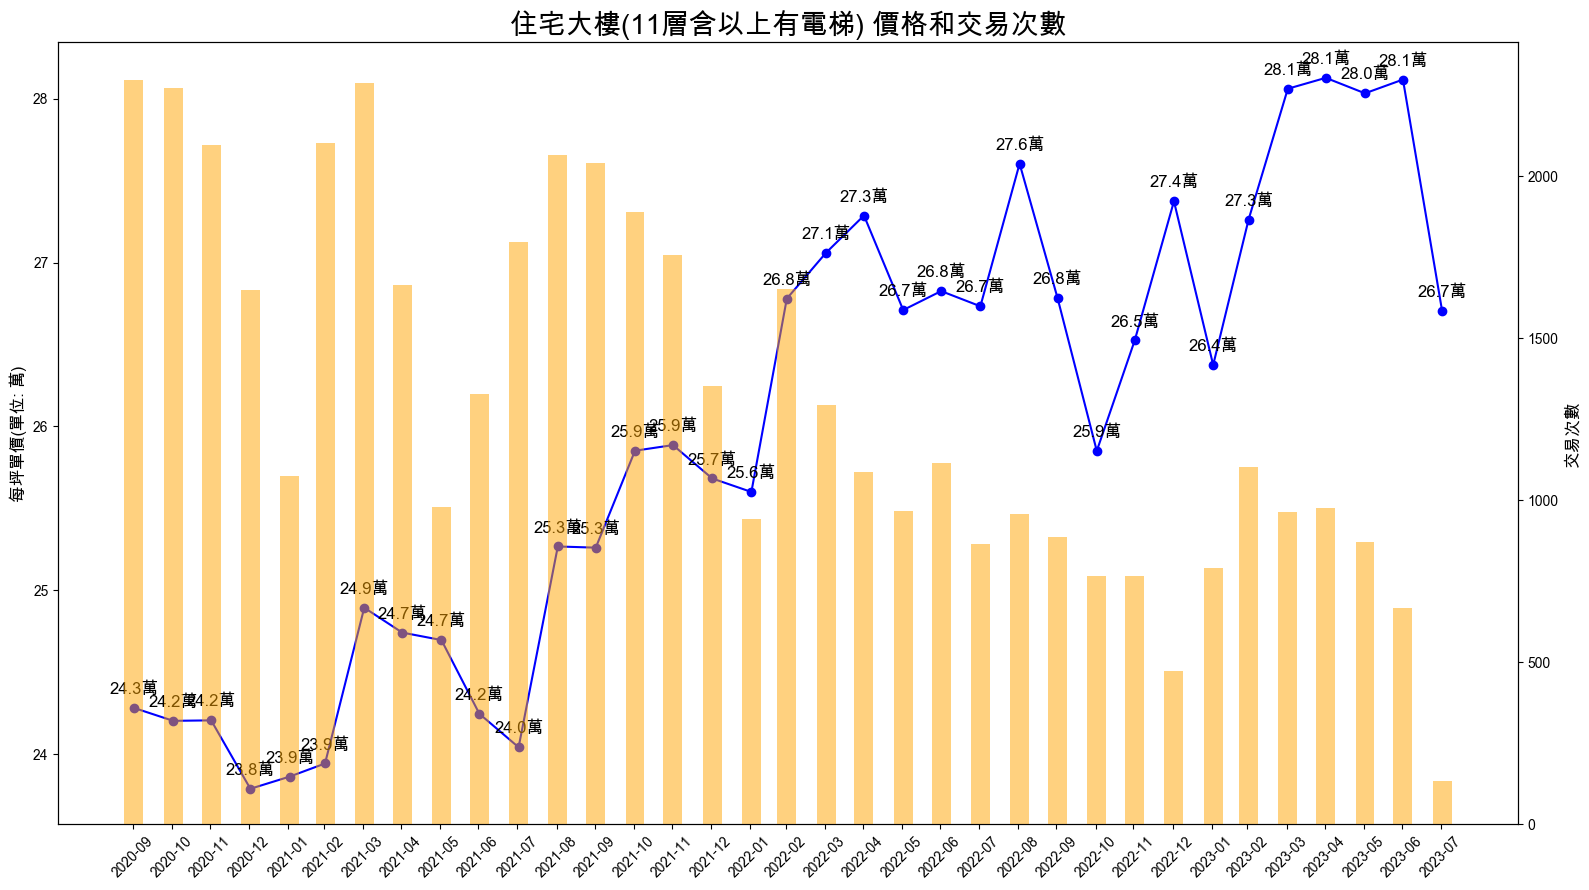

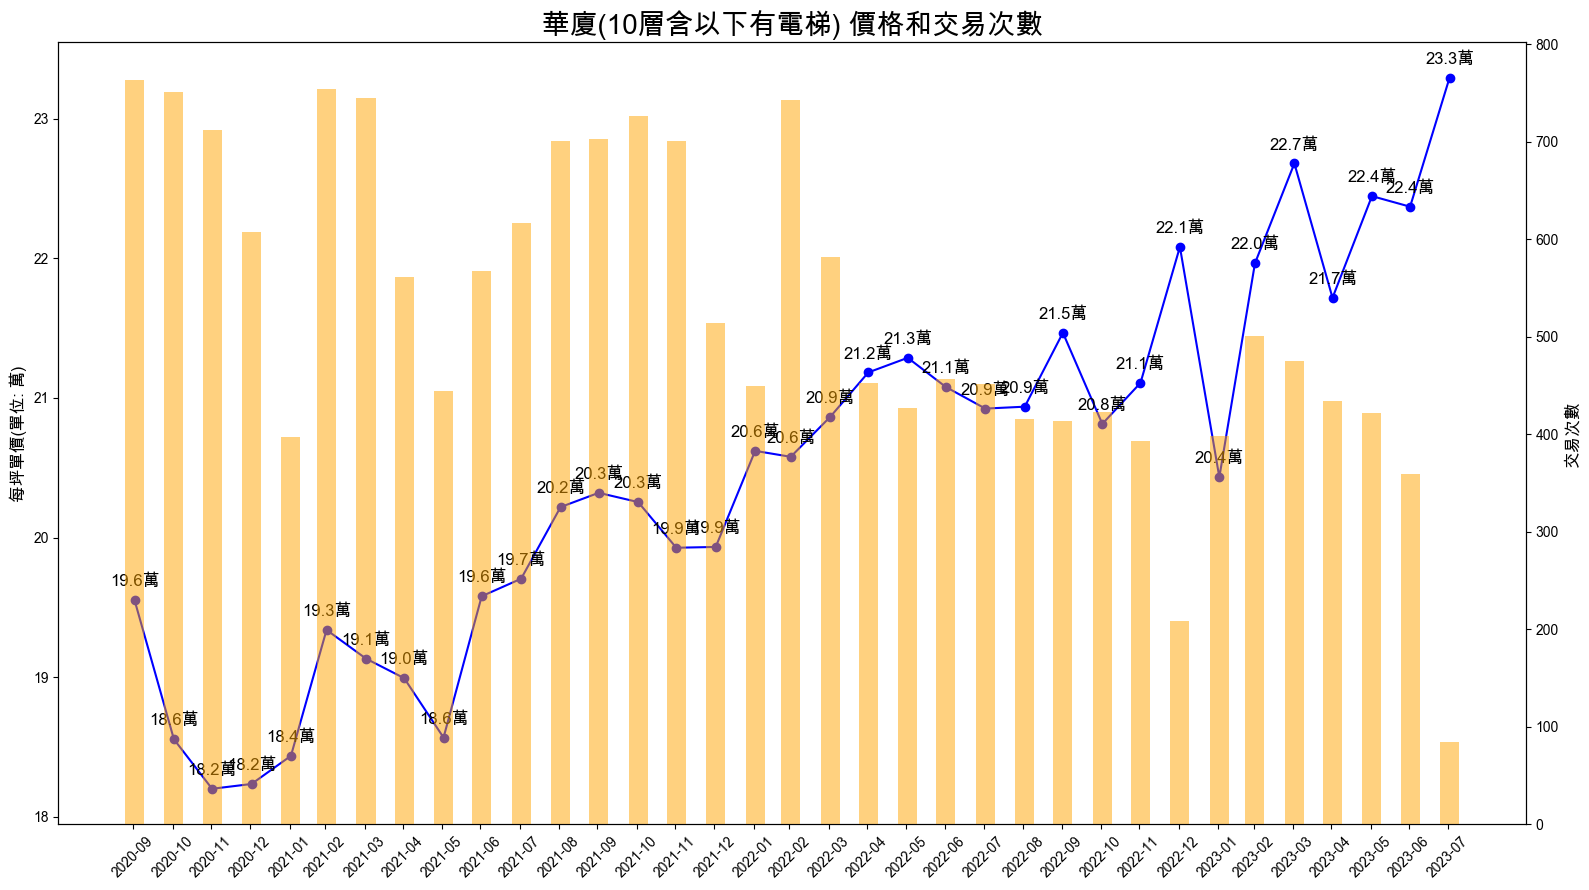

In [7]:
# Create a new DataFrame 'data2'
data2 = pd.DataFrame(data.groupby(['建物型態', 'Yearmonth'])['單價元坪'].mean()).reset_index()
data2['單價元坪'] = data2['單價元坪'] / 10000
property_type = ['公寓(5樓含以下無電梯)', '透天厝', '住宅大樓(11層含以上有電梯)', '華廈(10層含以下有電梯)']

for type in property_type:
    # Create a copy of data2
    data2_copy = data2[data2['建物型態'] == type]

    # Convert the Yearmonth column to datetime
    data2_copy.loc[:, 'Yearmonth'] = pd.to_datetime(data2_copy['Yearmonth'].astype(str), format='%Y-%m')

    # Sort the data by Yearmonth
    data2_copy = data2_copy.sort_values(by='Yearmonth')

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Line chart for average price
    ax1.plot(data2_copy['Yearmonth'], data2_copy['單價元坪'], marker='o', linestyle='-', color='b', label='Average Price')
    ax1.set_ylabel('每坪單價(單位: 萬)', fontsize=12)
    ax1.set_title(f'{type} 價格和交易次數', fontsize=20)
    ax1.tick_params(axis='x', labelrotation=45)

    # Annotate the data points on the line chart with data labels
    for i, txt in enumerate(data2_copy['單價元坪']):
        ax1.annotate(f'{txt:.1f}萬', (data2_copy['Yearmonth'].iloc[i], data2_copy['單價元坪'].iloc[i]),
                     textcoords="offset points", xytext=(0, 10), ha='center', size=12)

    # Create a second y-axis for the bar chart
    ax2 = ax1.twinx()
    
    # Bar chart for entry counts
    entry_counts = data[data['建物型態'] == type]['Yearmonth'].value_counts().sort_index()
    ax2.bar(data2_copy['Yearmonth'], entry_counts, alpha=0.5, color='orange', width=15, label='Entry Counts')
    ax2.set_ylabel('交易次數', fontsize=12)

    # Set the x-axis ticks and labels to display from September 2020 to August 2023
    ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
    ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                        rotation=45)

    # Adjust layout to prevent label overlap
    fig.tight_layout()

    # # save the plot with title named
    # filename = f'{type} 價格和交易次數.png'
    # plt.savefig(filename)

    # Show the chart
    plt.show()

In [8]:
for type in property_type:
    # Create a copy of data2
    data2_copy = data.copy()
    data2_copy = data2_copy[data2_copy['建物型態'] == type].groupby(['建物型態', 'Yearmonth']).size().reset_index(name='Transaction_Count')
    print(type)
    print(data2_copy[['Yearmonth', 'Transaction_Count']].transpose())

公寓(5樓含以下無電梯)
                        0        1        2        3        4        5   \
Yearmonth          2020-10  2020-11  2020-12  2021-01  2021-02  2021-03   
Transaction_Count      241      257      237      206      103      244   

                        6        7        8        9   ...       25       26  \
Yearmonth          2021-04  2021-05  2021-06  2021-07  ...  2022-11  2022-12   
Transaction_Count      240      211      131      180  ...      172      185   

                        27       28       29       30       31       32  \
Yearmonth          2023-01  2023-02  2023-03  2023-04  2023-05  2023-06   
Transaction_Count      109      169      262      199      188      213   

                        33       34  
Yearmonth          2023-07  2023-08  
Transaction_Count      147       40  

[2 rows x 35 columns]
透天厝
                        0        1        2        3        4        5   \
Yearmonth          2020-10  2020-11  2020-12  2021-01  2021-02  2021-03   
Tra

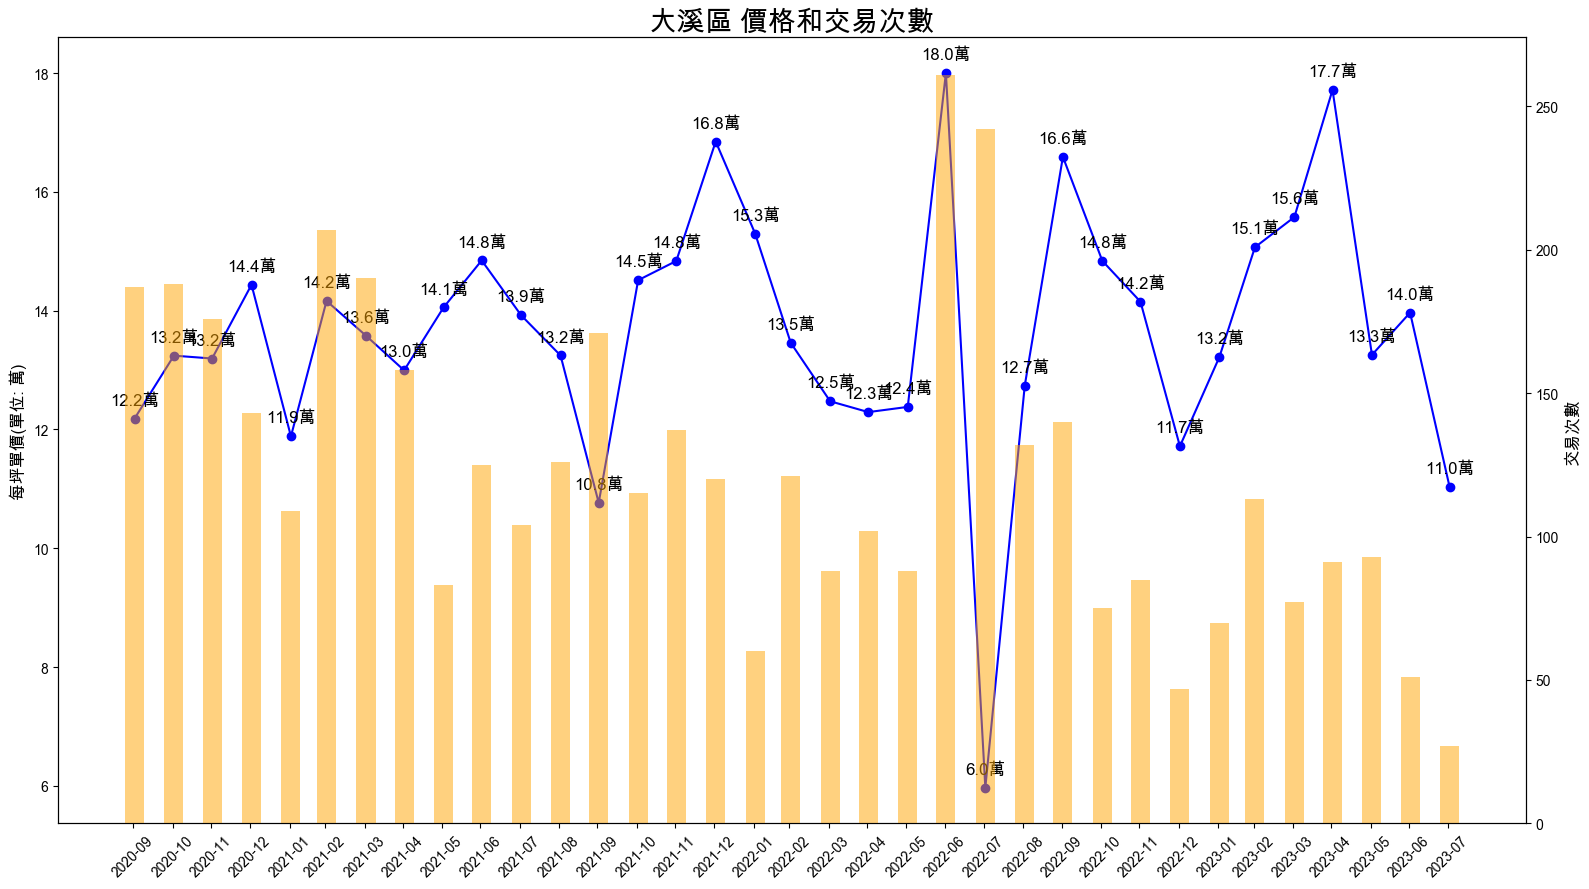

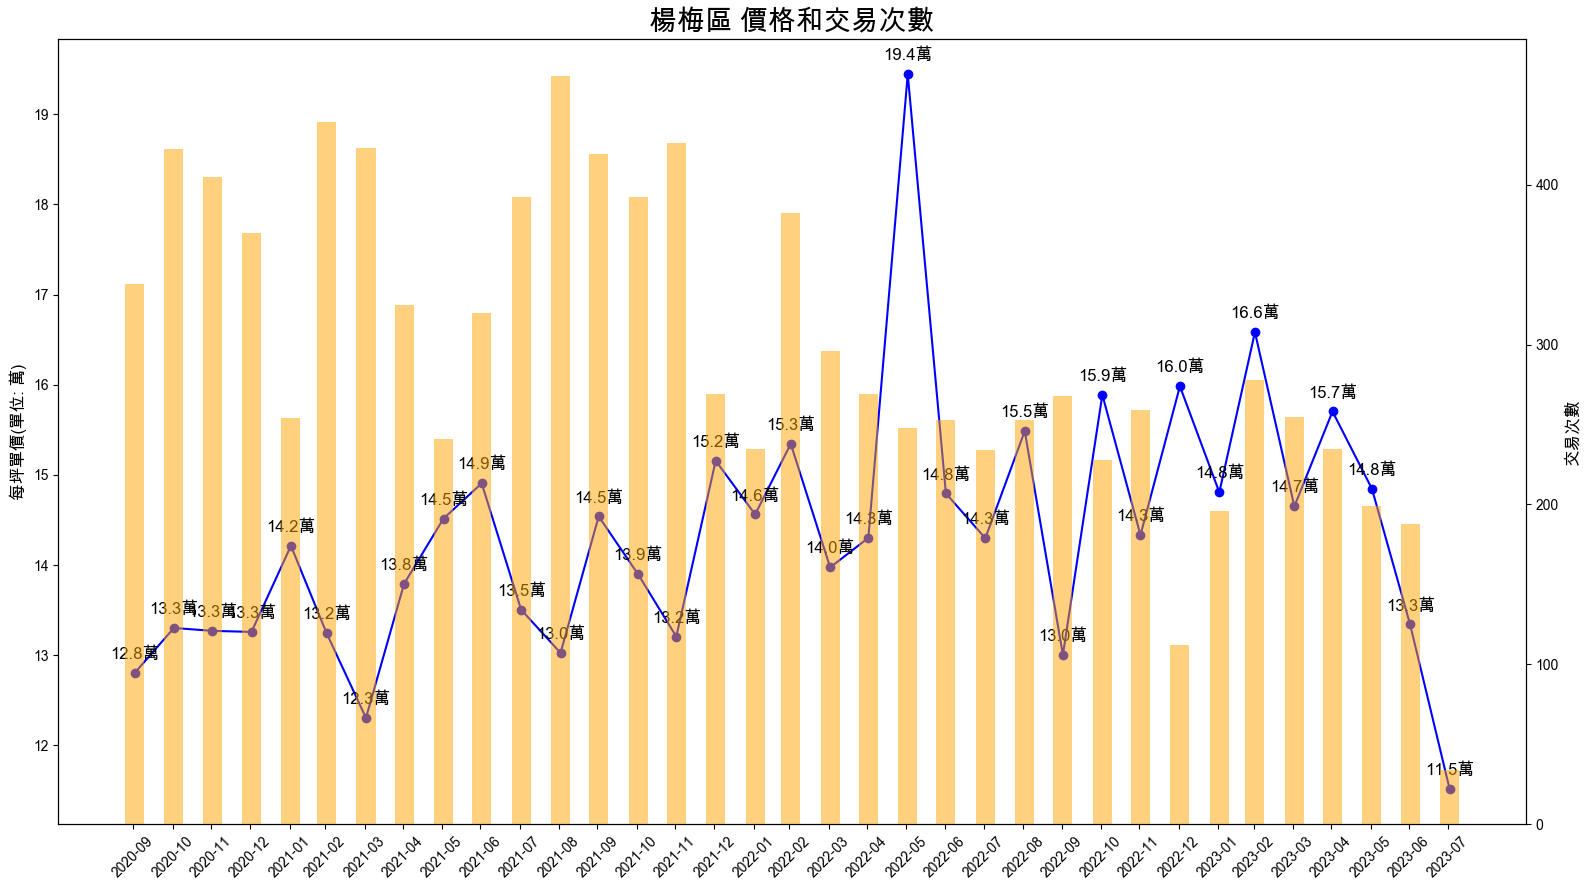

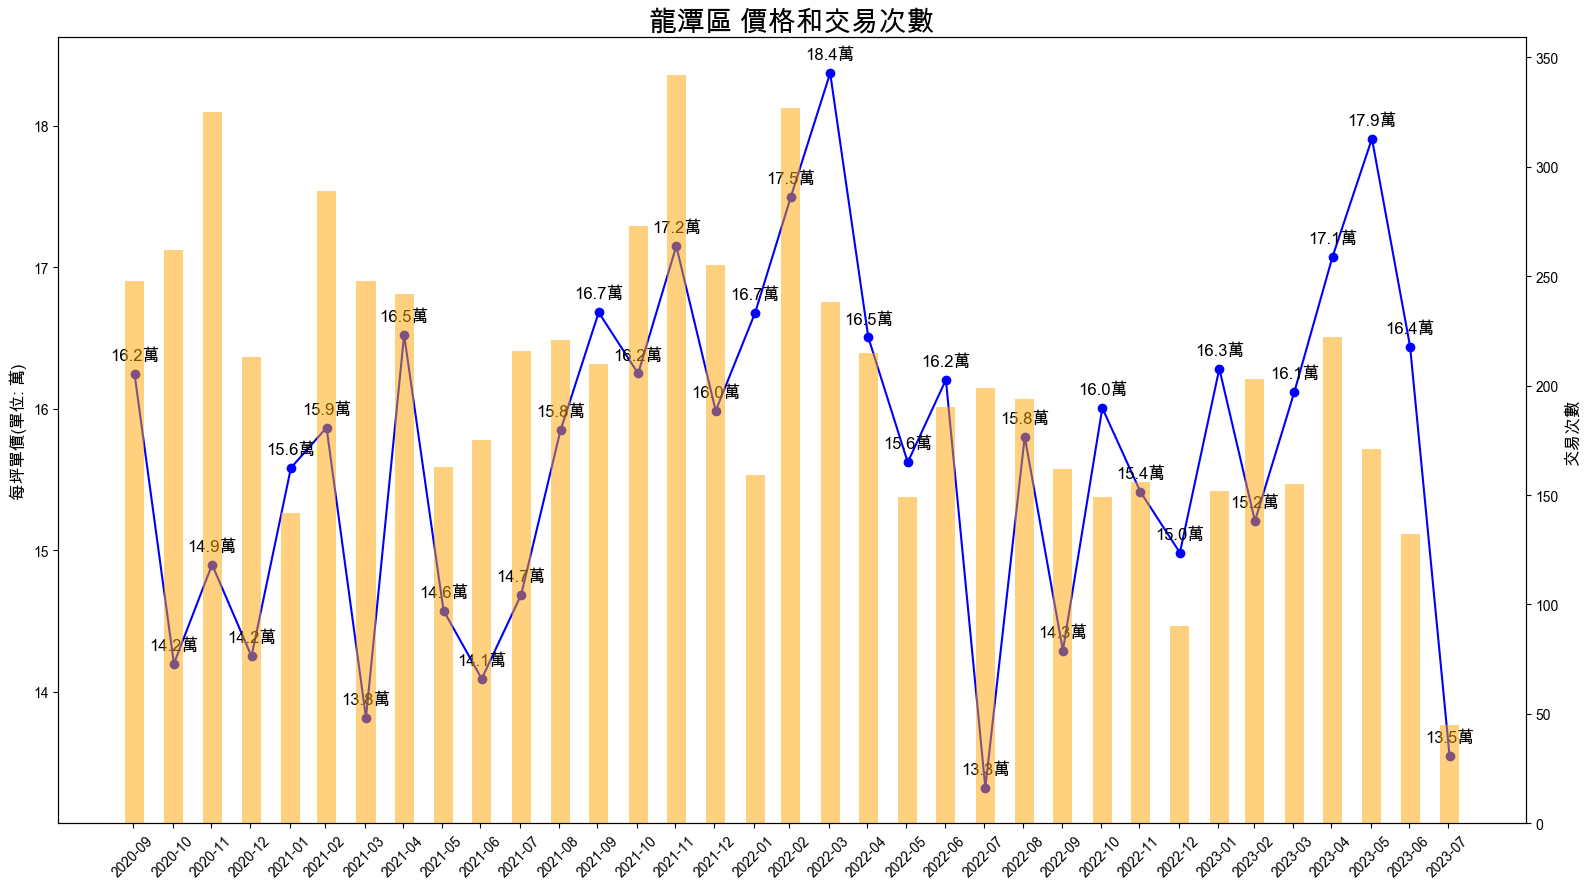

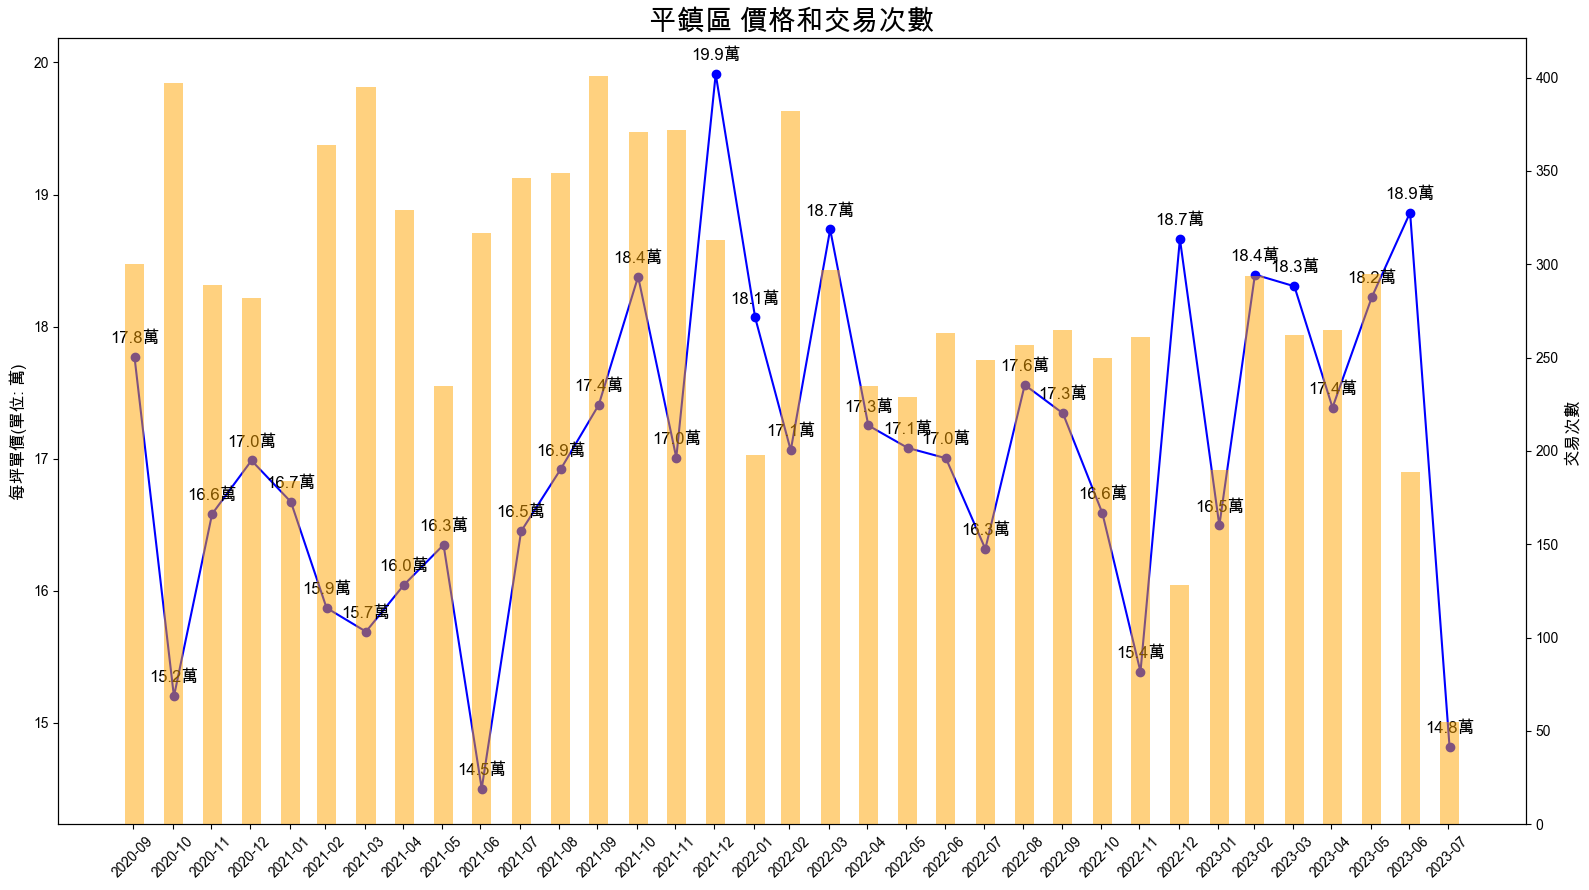

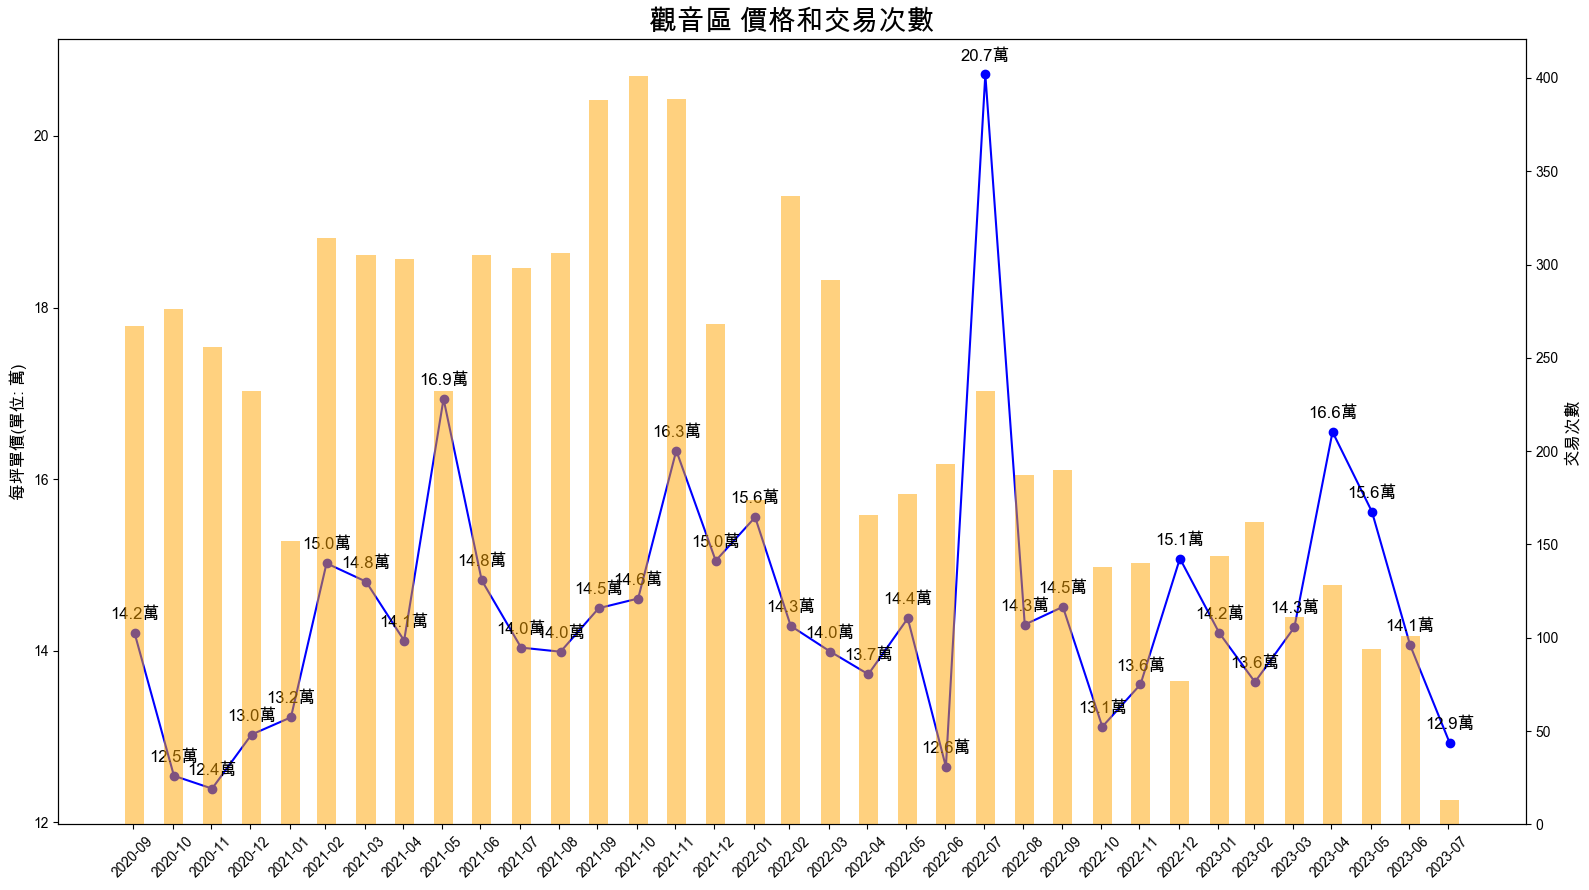

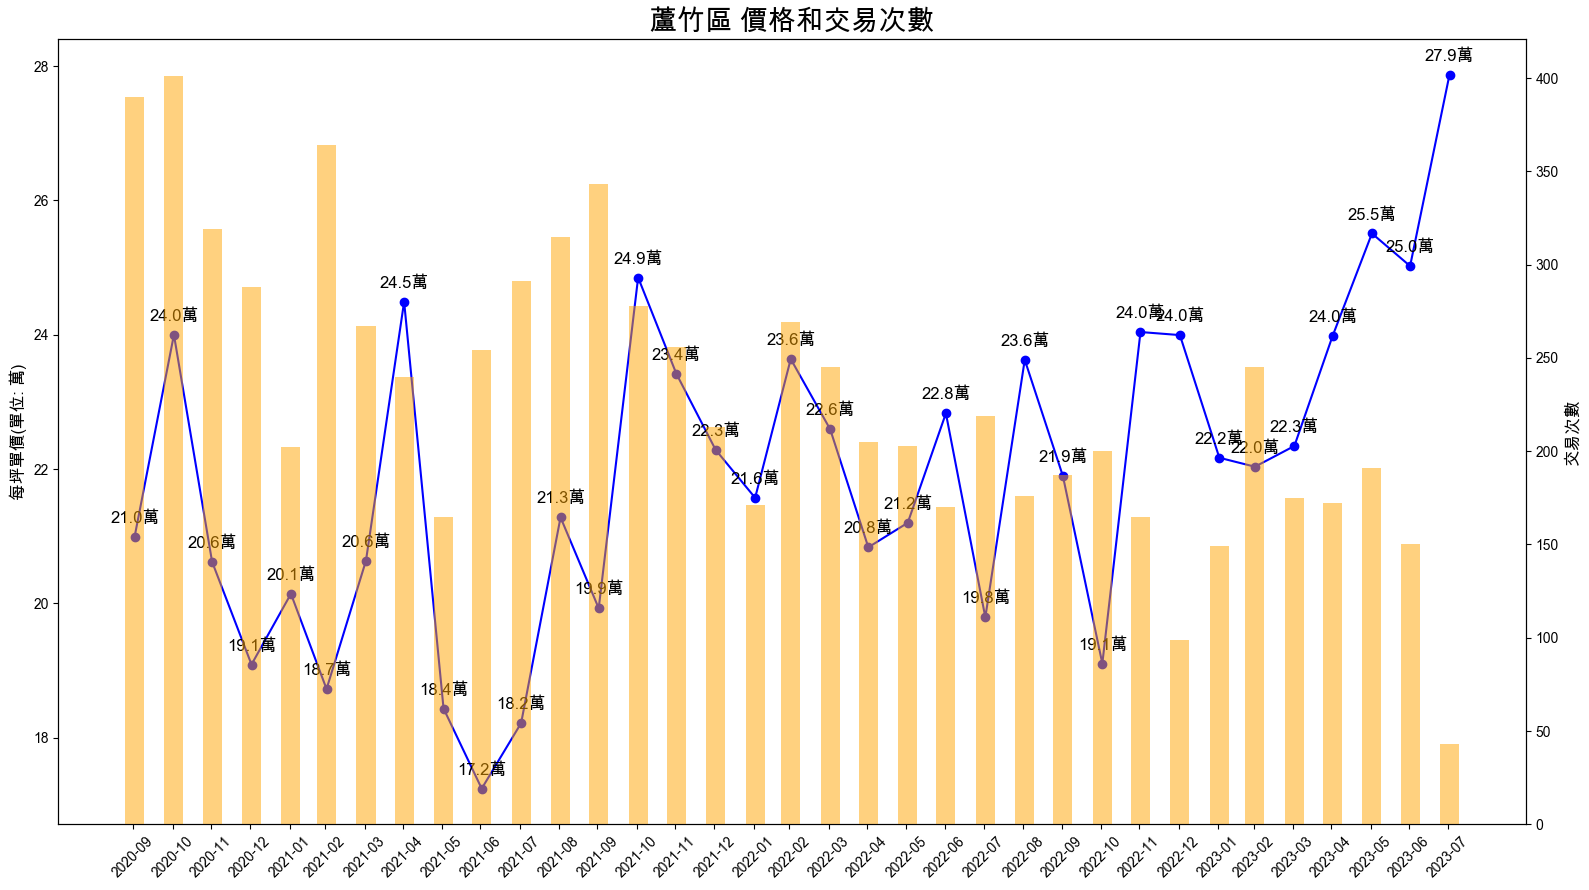

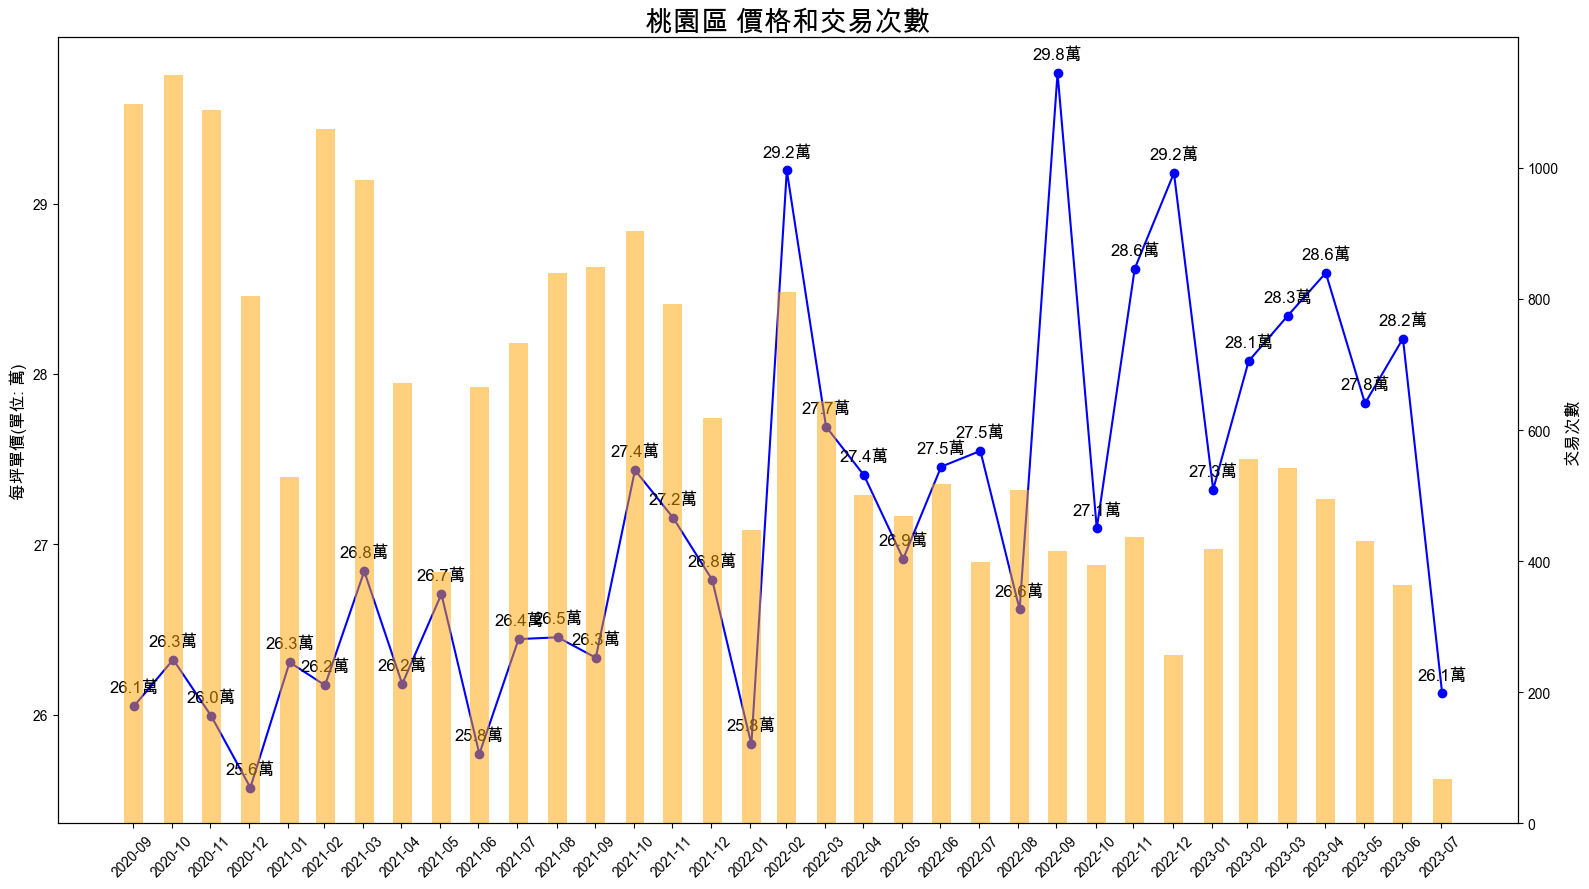

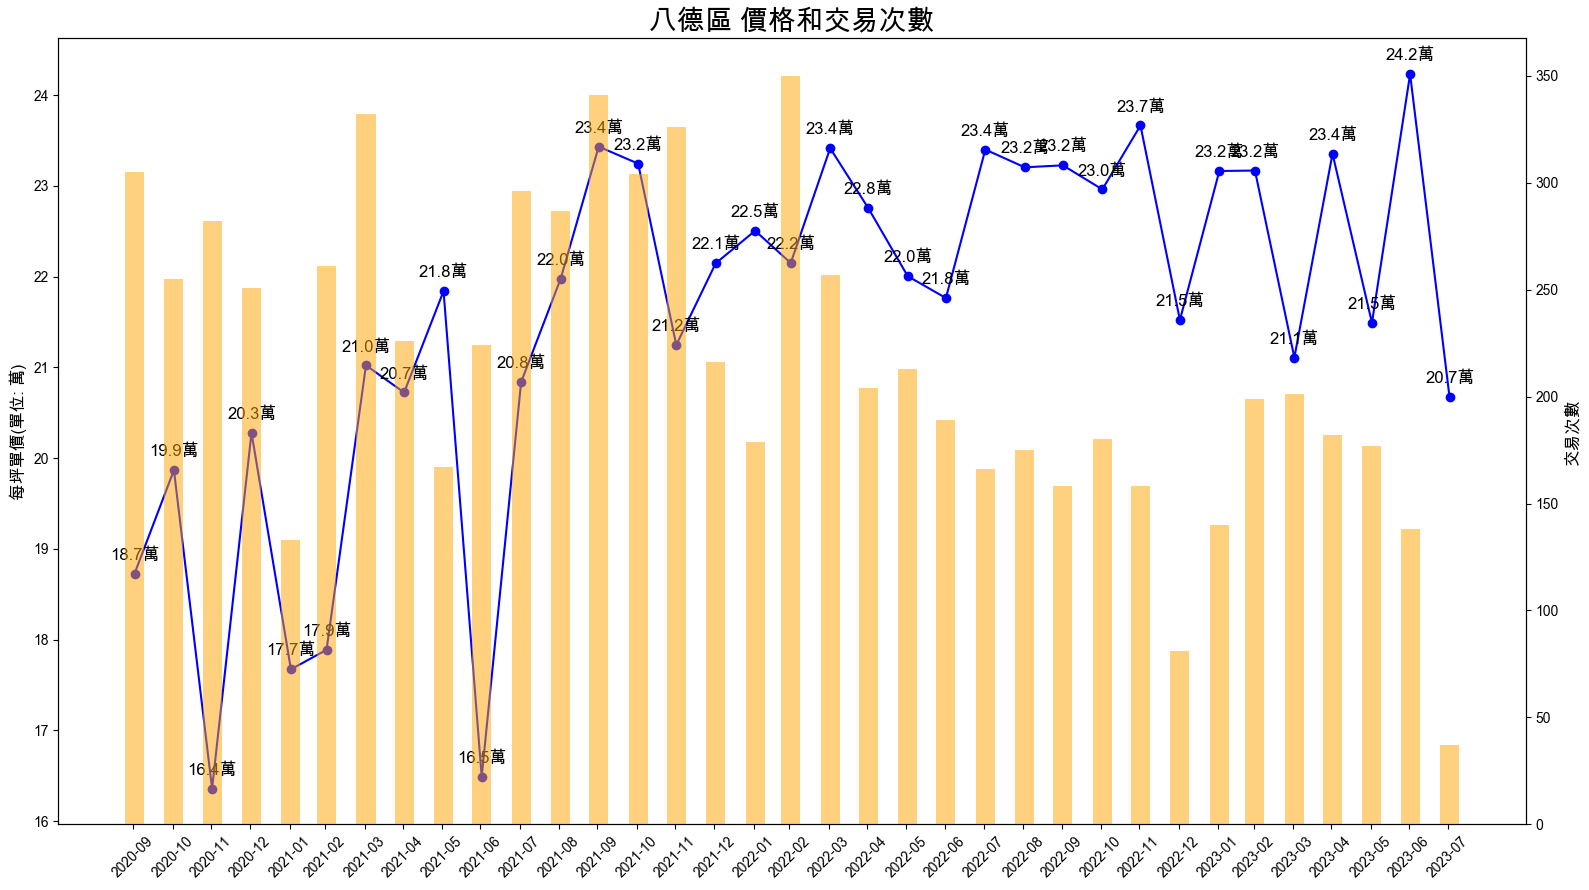

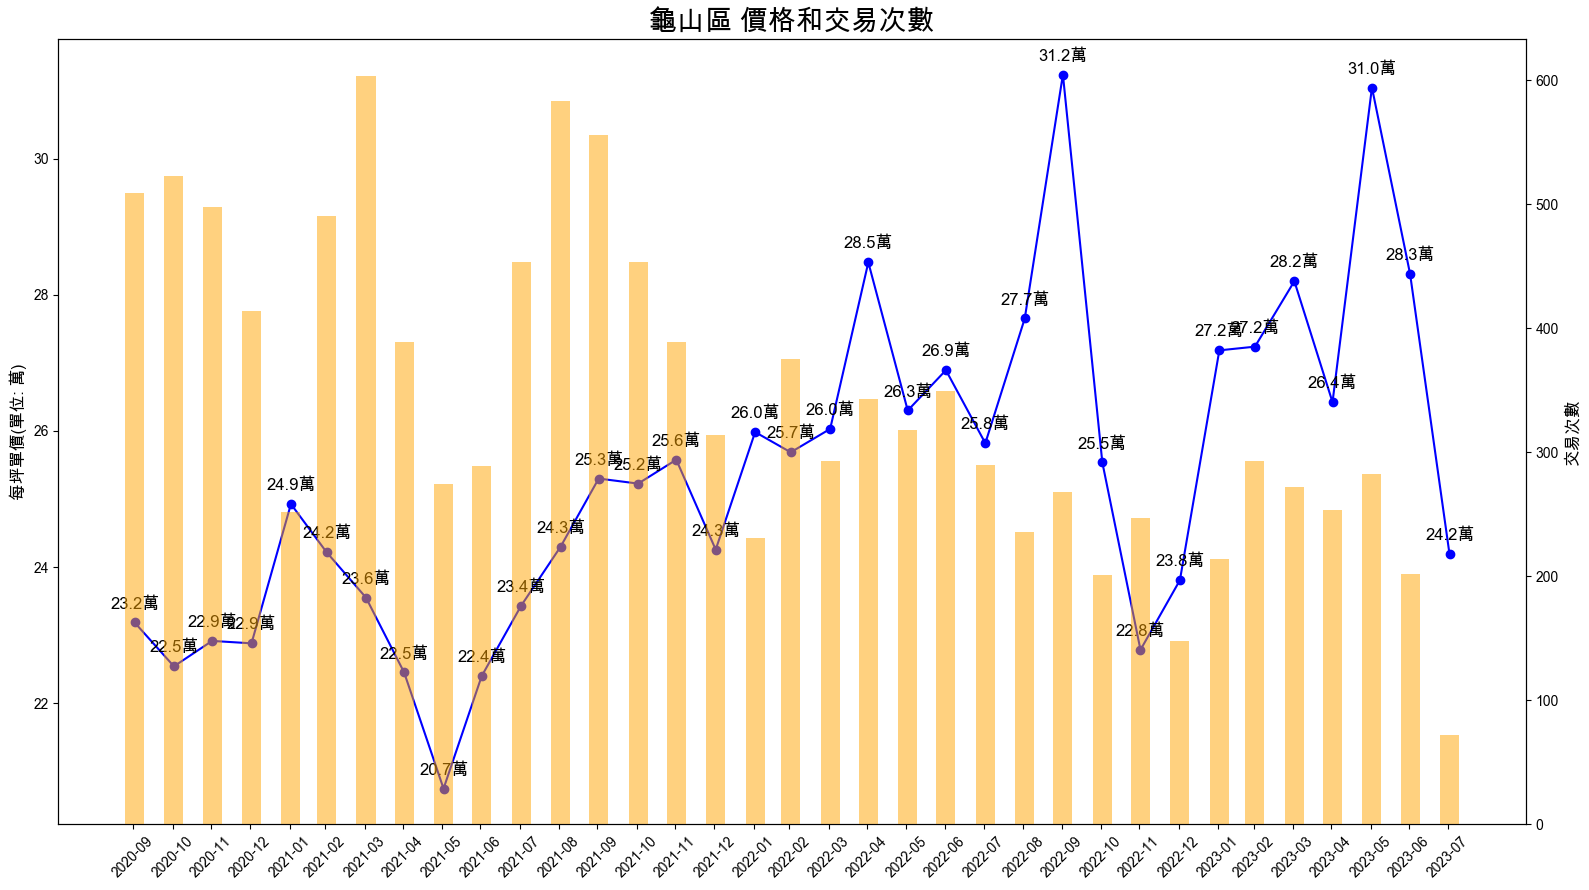

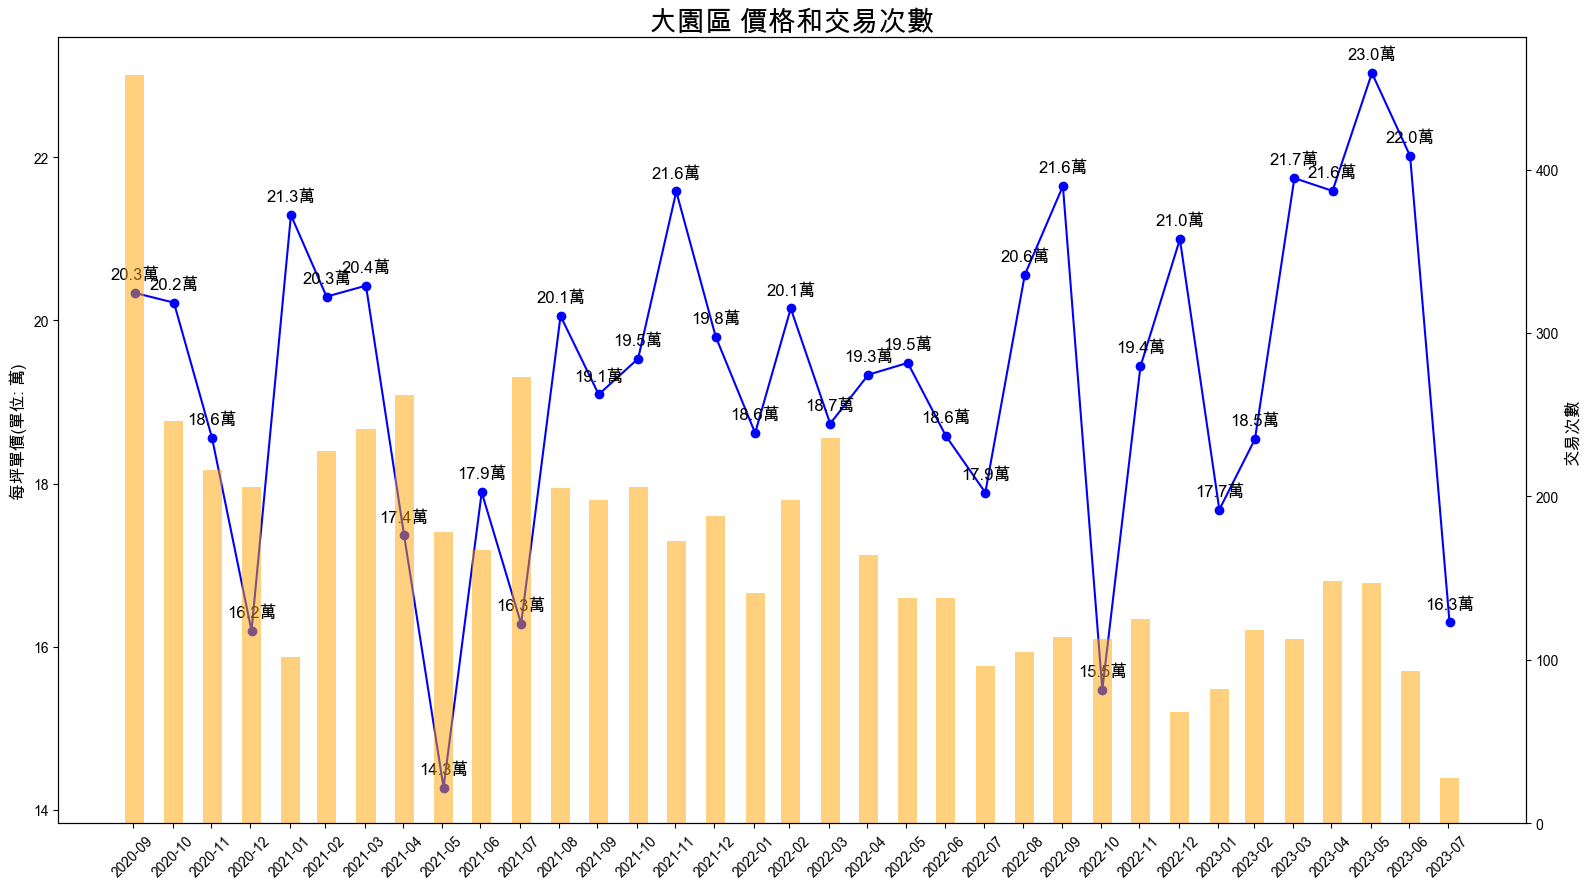

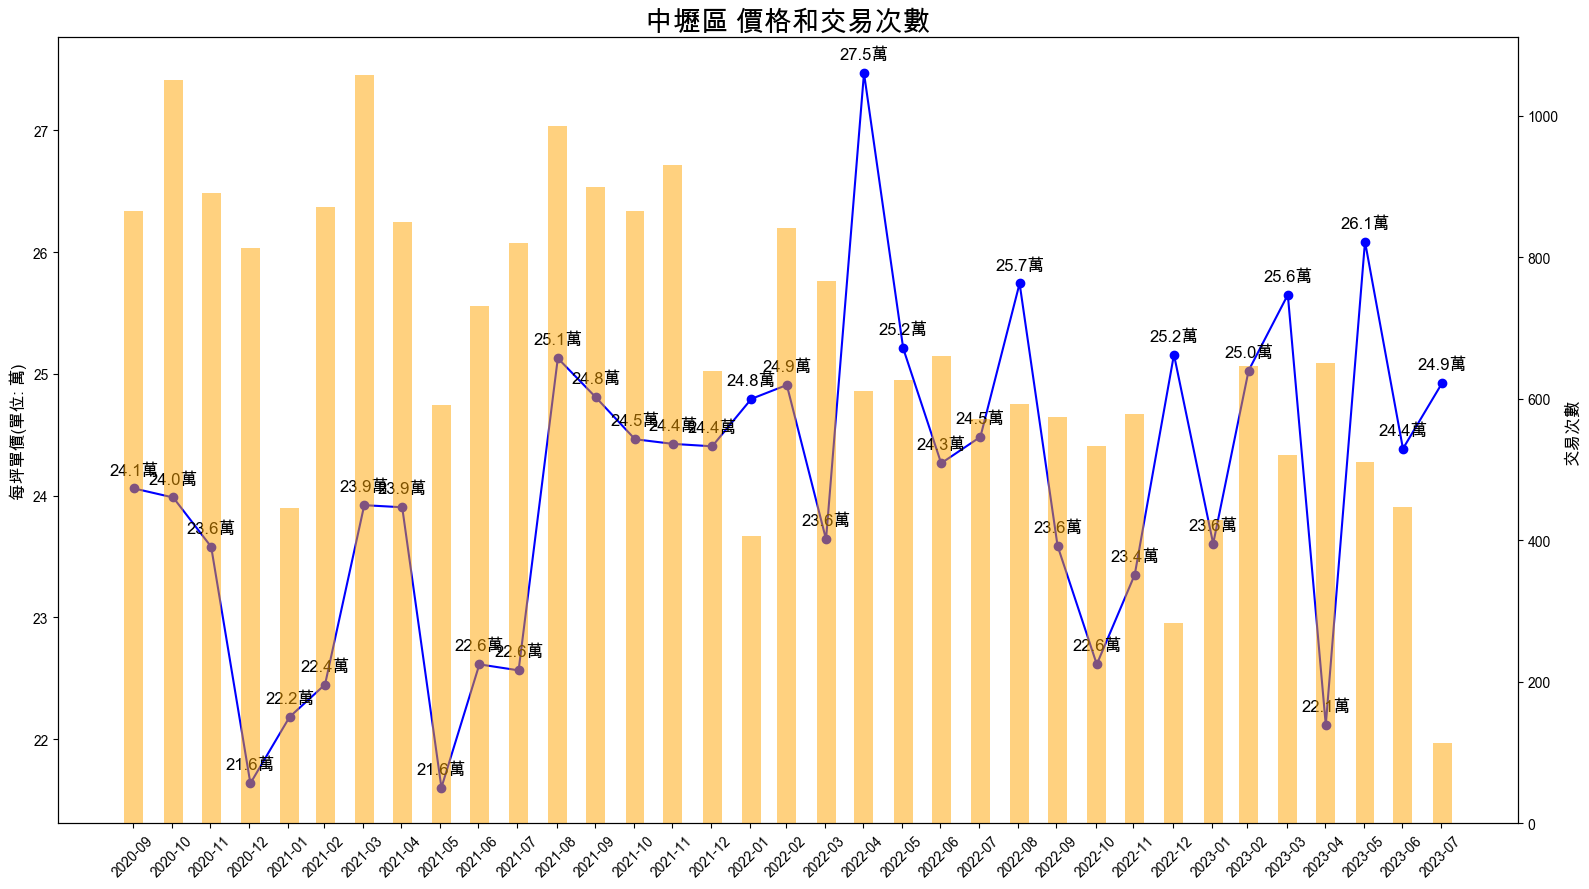

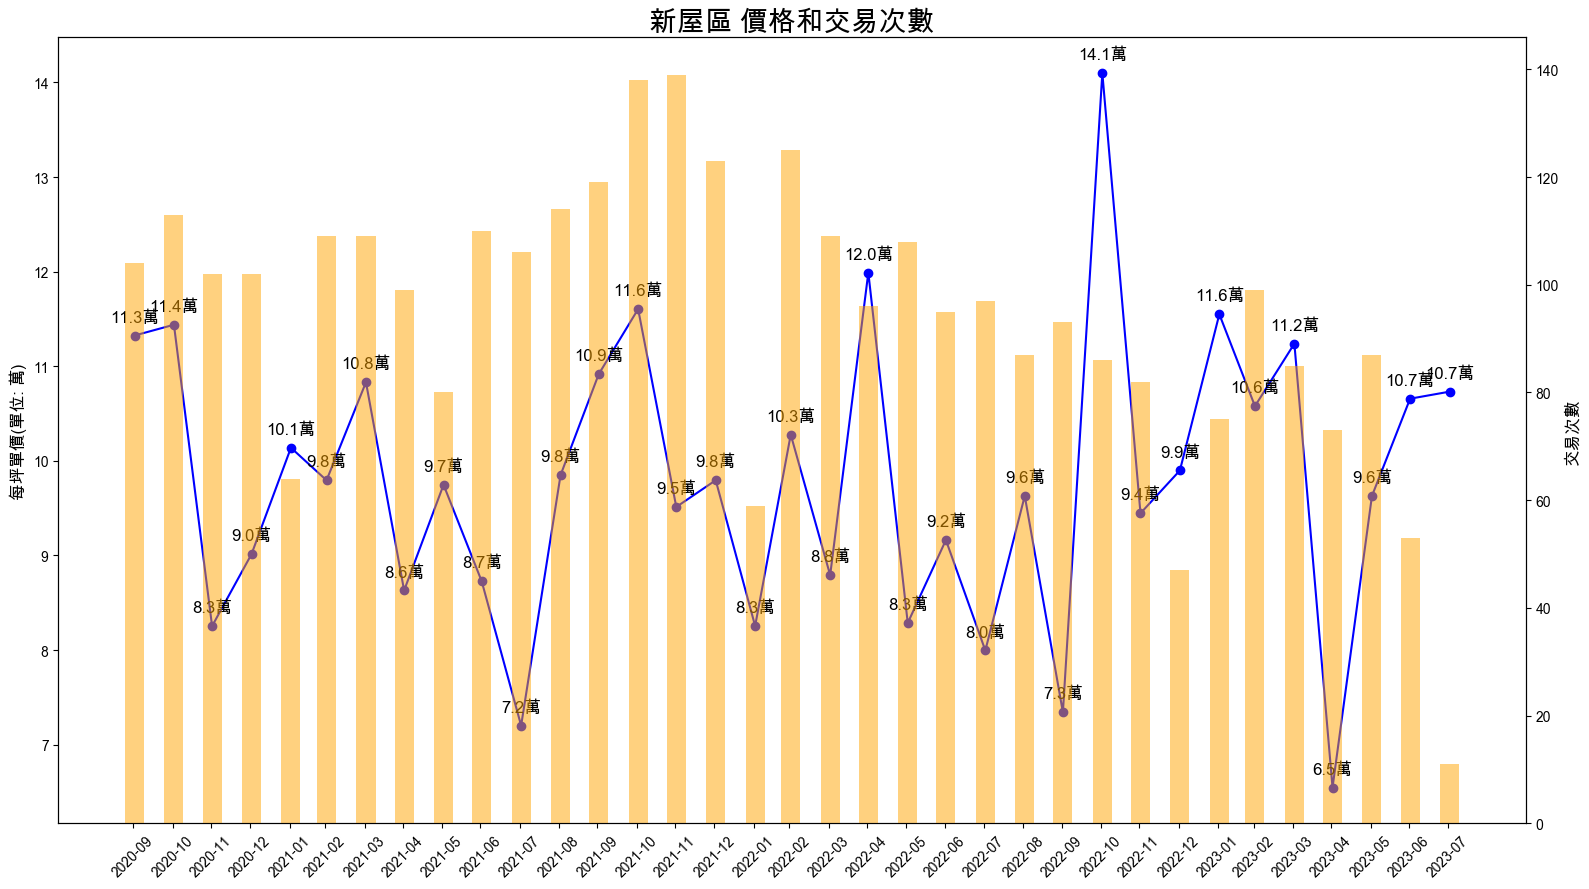

In [9]:
# Create a new DataFrame 'data3'
data3 = pd.DataFrame(data.groupby(['鄉鎮市區', 'Yearmonth'])['單價元坪'].mean()).reset_index()
data3['單價元坪'] = data3['單價元坪'] / 10000
dist = ['大溪區', '楊梅區', '龍潭區', '平鎮區', '觀音區', '蘆竹區', '桃園區', '八德區', '龜山區', '大園區', '中壢區', '新屋區']

for area in dist:
    # Create a copy of data3
    data3_copy = data3.copy()
    
    # Filter data for the specific district
    data3_copy = data3_copy[data3_copy['鄉鎮市區'] == area]

    # Convert the Yearmonth column to datetime
    data3_copy['Yearmonth'] = pd.to_datetime(data3_copy['Yearmonth'].astype(str), format='%Y-%m')

    # Sort the data by Yearmonth
    data3_copy = data3_copy.sort_values(by='Yearmonth')

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Line chart for average price
    ax1.plot(data3_copy['Yearmonth'], data3_copy['單價元坪'], marker='o', linestyle='-', color='b', label='Average Price')
    ax1.set_ylabel('每坪單價(單位: 萬)', fontsize=12)
    ax1.set_title(f'{area} 價格和交易次數', fontsize=20)
    ax1.tick_params(axis='x', labelrotation=45)

    # Annotate the data points on the line chart with data labels
    for i, txt in enumerate(data3_copy['單價元坪']):
        ax1.annotate(f'{txt:.1f}萬', (data3_copy['Yearmonth'].iloc[i], data3_copy['單價元坪'].iloc[i]),
                     textcoords="offset points", xytext=(0, 10), ha='center', size=12)

    # Create a second y-axis for the bar chart
    ax2 = ax1.twinx()
    
    # Bar chart for transaction counts
    entry_counts = data[data['鄉鎮市區'] == area]['Yearmonth'].value_counts().sort_index()
    ax2.bar(data3_copy['Yearmonth'], entry_counts, alpha=0.5, color='orange', width=15, label='Transaction Counts')
    ax2.set_ylabel('交易次數', fontsize=12)

    # Set the x-axis ticks and labels to display from September 2020 to August 2023
    ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
    ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                        rotation=45)

    # Adjust layout to prevent label overlap
    fig.tight_layout()

    # # save the plot with title named
    # filename = f'{area} 價格和交易次數.png'
    # plt.savefig(filename)

    # Show the chart
    plt.show()

In [10]:
for area in dist:
    # Create a copy of data3
    data3_copy = data.copy()
    data3_copy = data3_copy[data3_copy['鄉鎮市區'] == area].groupby(['鄉鎮市區', 'Yearmonth']).size().reset_index(name='Transaction_Count')
    print(area)
    print(data3_copy[['Yearmonth', 'Transaction_Count']].transpose())

大溪區
                        0        1        2        3        4        5   \
Yearmonth          2020-10  2020-11  2020-12  2021-01  2021-02  2021-03   
Transaction_Count      187      188      176      143      109      207   

                        6        7        8        9   ...       25       26  \
Yearmonth          2021-04  2021-05  2021-06  2021-07  ...  2022-11  2022-12   
Transaction_Count      190      158       83      125  ...       75       85   

                        27       28       29       30       31       32  \
Yearmonth          2023-01  2023-02  2023-03  2023-04  2023-05  2023-06   
Transaction_Count       47       70      113       77       91       93   

                        33       34  
Yearmonth          2023-07  2023-08  
Transaction_Count       51       27  

[2 rows x 35 columns]
楊梅區
                        0        1        2        3        4        5   \
Yearmonth          2020-10  2020-11  2020-12  2021-01  2021-02  2021-03   
Transaction_

In [11]:
from pathlib import Path
data_filename = '2020Q3-2023Q3_Taoyaun_property_data.csv'
full_path = Path.cwd() / data_filename  # Constructing the full path

data.to_csv(full_path, index=False)